## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 26.02.24 MSK**

**Дедлайн: 4.03.24 MSK**

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению

In [6]:
df = pd.read_csv('./data/interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [7]:
df.shape

(5476250, 5)

In [8]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min()) # приводим данные к относительным значениям(относительно min)
print(df['last_watch_dt'][1:4])
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0])) # перевели d целые числа 
df.sample(5)

1    77 days
2    57 days
3   114 days
Name: last_watch_dt, dtype: timedelta64[ns]


,user_id,item_id,last_watch_dt,total_dur,watched_pct
3169288,822133,142,103,177,3.0
4552797,801415,5398,105,15,0.0
3887352,1009908,12360,154,22,0.0
3033989,167077,3541,99,212,4.0
2776578,387980,12598,139,2436,42.0


In [9]:
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,59,4250,72.0
1,699317,1659,77,8317,100.0
2,656683,7107,57,10,0.0
3,864613,7638,114,14483,100.0
4,964868,9506,48,6725,100.0


Сделаем разбиение по времени

<Axes: >

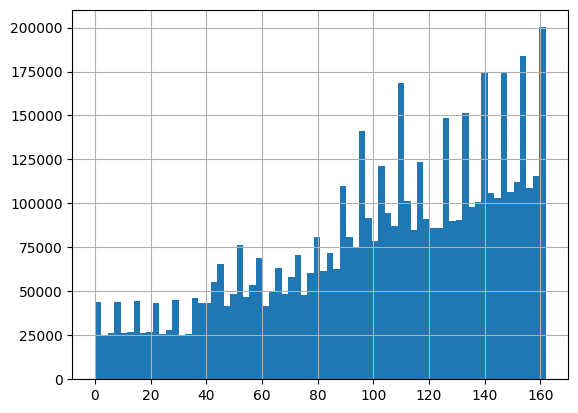

In [10]:
df.last_watch_dt.hist(bins=70)

In [11]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users) #пересечения уникальных пользовательских идентификаторов между `train_users` и `test_users`

print('число людей и в train и в test: ', all_included.shape[0]) # пересечений
print('число людей всего в train:', train_users.shape[0]) 

число людей и в train и в test:  134670
число людей всего в train: 880449


In [12]:
all_included

array([      3,       9,      17, ..., 1097521, 1097525, 1097544],
      dtype=int64)

In [13]:
len(set(test_users) - set(train_users)) / len(test_users) #уникальных пользователей из множества test_users, которые отсутствуют в множестве train_users.
#доля пользователей, которые есть только в тестовом наборе.

0.37768022181146027

In [14]:
len(set(train_users) - set(test_users)) / len(train_users) # доля пользователей, которые есть только в train

0.8470439514384138

И переведём всё к соединённому датасету

In [15]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy() # уникальных пользователей из массива `all_included` без повторений.
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy() 

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min() # максимальная дата в тренировочном наборе меньше минимальной даты в тестовом наборе
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [16]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
28,81786,2616,133,41422,90.0
30,1057871,6208,152,5033,95.0
51,787115,11835,119,3283,54.0
85,910002,11143,151,710,10.0
204,413440,7310,132,1,0.0


In [17]:
test_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
6,1016458,354,154,1672,25.0
748,519279,5974,157,102,1.0
965,727679,3472,162,2049,40.0
1048,480279,7829,155,46,1.0
1118,635651,16442,157,2873,50.0


In [18]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda x: x[1])] ).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)
#  train_df группируется по 'user_id', после чего для каждой группы для каждого пользователя создается 
# список кортежей (t1, t2), где t1 - это значение 'item_id', а t2 - значение 'last_watch_dt', отсортированные по возрастанию даты
test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id, x.last_watch_dt), key=lambda x: x[1])] ).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)
#сводные таблицы для тренировочного и тестового наборов данных, содержащие отсортированные интеракции пользователей с товарами по времени просмотра!!!
train_grouped.head()

,user_id,train_interactions
0,17,"[(3734, 141), (10196, 146), (8618, 146)]"
1,55,"[(9896, 15), (6192, 60), (3076, 99), (15297, 1..."
2,165,"[(12173, 122)]"
3,170,"[(13237, 152), (4331, 152)]"
4,272,"[(12869, 40), (11310, 112)]"


In [19]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,17,"[(3734, 141), (10196, 146), (8618, 146)]","[(9342, 155)]"
1,55,"[(9896, 15), (6192, 60), (3076, 99), (15297, 1...","[(14, 156)]"
2,165,"[(12173, 122)]","[(4969, 161)]"
3,170,"[(13237, 152), (4331, 152)]","[(1453, 153), (741, 154), (15679, 154), (11083..."
4,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214..."


In [20]:
np.random.seed(777)

class Random:
    """ 
    Служит для предсказания topn случайных элементов из обученной модели для каждой строки DataFrame, 
    где каждая строка представляет пользователя или сущность, для которой формируются рекомендации
    """

    def __init__(self): # метод-конструктор

        self.trained = False

    def fit(self, df, col='train_interactions'):
        """
        извлекает уникальные элементы из списка интераций в этом столбце и сохраняет их в объекте класса Random.
        """
        items = set()
        for _, row in df.iterrows(): # итерация по строкам 
            for item, _ in row[col]: # Для каждой строки извлекается столбец col, содержащий список кортежей 
                #(например, [(item1, time1), (item2, time2), ...]), итерируется по этому списку.
                items.add(item) # Каждый элемент item из кортежей добавляется во множество items.

        self.items = list(items) # все уникальные элементы(запросы) сохраняются в виде списка в атрибуте items объекта класса Random.
        self.trained = True

    def predict(self, df, topn=10):
        """
        Параметр topn, который определяет количество элементов для предсказания.
        Этот метод возвращает список случайно выбранных элементов из сохраненного списка items.
        """
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df) #  для случайного выбора topn элементов из списка self.items без повторений (replace=False)
                                                                                # затем повторяем len(df) раз


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,17,"[(3734, 141), (10196, 146), (8618, 146)]","[(9342, 155)]","[3520, 15874, 12549]"
1,55,"[(9896, 15), (6192, 60), (3076, 99), (15297, 1...","[(14, 156)]","[3520, 15874, 12549]"
2,165,"[(12173, 122)]","[(4969, 161)]","[3520, 15874, 12549]"
3,170,"[(13237, 152), (4331, 152)]","[(1453, 153), (741, 154), (15679, 154), (11083...","[3520, 15874, 12549]"
4,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214...","[3520, 15874, 12549]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$

------------------------------------------------------------------------------------------------------------------

Для вычисления Average Precision (AP) нужно выполнить следующие шаги:
1. **Оценить релевантность предсказаний:**
   - На основе истинных значений и предсказаний оценить, какие из предсказанных элементов являются "верными" релевантными элементами.

2. **Вычислить Precision at k и Average Precision:**
   - Для каждого элемента рассчитать Precision at k (precision@k) до k-го элемента (если не задано, то до конца списка).
   - Average Precision - усредненное значение precision на каждом шаге, где оценено, как много "верных" элементов найдено на момент каждого шага.

In [21]:
from typing import List, Optional
import numpy as np
##Average Precision (AP) TEST TEST TEST TEST TEST 
# def ap_metric( gt_items: List[int], predictions: List[int], topn: Optional[int]=None ):

#     if topn is not None: 
#         predictions = np.array(predictions[:topn]) # первые topn предсказания

#     num_hits = 0
#     score = 0.0
#     for i, p in enumerate(predictions):
#         if p in gt_items and p not in predictions[:i]:
#             num_hits += 1
#             score += num_hits / (i + 1)

#     # if not gt_items:
#     #     return 0.0
#     avg_precision = score / min(len(gt_items), len(predictions))
#     return avg_precision
# # Пример использования
# gt_items = [1, 2, 3, 4, 5]
# predictions = [6, 4, 1, 7, 5]
# topn = 3  # Если хотим оценить до первых трех предсказаний
# ap = ap_metric(gt_items, predictions, topn)
# print(ap)


In [22]:
from typing import List, Optional
import numpy as np

def ap_metric(gt_items: List[int], predictions: List[int], topn: Optional[int] = None):
    
    if topn is not None:
        predictions = np.array(predictions[:topn])  # Преобразование в NumPy array для более эффективной работы

    # Создание маски для проверки наличия предиктов среди правильных значений
    correct_mask = np.in1d(predictions, gt_items, assume_unique=True)
    
    # Вычисление накопленной суммы корректных предиктов до каждой позиции
    cumulative_hits = np.cumsum(correct_mask)
    
    # Число позиций для каждого предикта
    positions = np.arange(1, len(predictions) + 1)
    
    # Вычисление precision at k
    precision_at_k = cumulative_hits / positions
    
    # Индексы релевантных предиктов
    relevant_indices = np.where(correct_mask)[0]  # мб + 1...... но тогда выход за границы массива
    
    # Расчет среднего precision
    avg_precision = np.sum(precision_at_k[relevant_indices]) / min(len(gt_items), len(predictions)) 
    
    # Обработка случаев, когда нет правильных значений
    # if not gt_items:
    #     return 0.0

    return avg_precision

# Пример использования
gt_items = [1, 2, 3, 4, 5]
predictions = [6, 4, 1, 7, 5]
topn = 3  # Если хотим оценить до первых трех предсказаний
ap = ap_metric(gt_items, predictions, topn)
print(ap)

0.38888888888888884


1. Reciprocal Rank at k (RR@k):
    - Это метрика, которая оценивает способность модели предсказывать релевантные элементы, инвертируя позицию первого релевантного элемента среди первых k предсказаний.
    - Формула для RR@k: RR@k = 1/(rank_i@k)
    - Здесь rank_i@k - это позиция первого релевантного элемента среди первых k предсказаний.

Например, если для конкретного пользователя первый релевантный элемент находится на третьей позиции среди первых k предсказаний, то RR@k будет равняться 1/3 = 0.33. Чем ближе значение RR@k к 1, тем лучше модель способна предсказывать релевантные элементы раньше.

RR@k полезно использовать как метрику эффективности модели в задачах рекомендаций, поскольку она фокусируется не только на том, насколько верный сам предсказанный элемент, но и на его ранжировании среди остальных предсказаний.

RR отражает, как скоро в среднем мы сможем найти релевантный элемент для каждого пользователя на первых K позициях. Это подчеркивает важность правильной позиции в начале списка.

In [23]:
# def rr_metric(gt_items: List[int], predictions: List[int], topn: Optional[int]=None): 
#     if topn is None:
#         predictions = predictions[:topn]

#     rr_score = 0.0 
    
#     if gt_items[0] != predictions[0] and topn == 1:
#         return rr_score
    
#     for idx, p in enumerate(predictions):
#         if p in gt_items:
#             rr_score = 1 / (idx + 1)
#             break
    
#     return rr_score

# gt_items = [1, 2, 3, 4, 5]
# predictions = [6, 4, 1, 7, 5]
# topn = 1  # Если хотим оценить до первых трех предсказаний
# rr = rr_metric(gt_items, predictions, topn)
# print(rr)

In [70]:
# векторизовал..
def rr_metric(gt_items: List[int], predictions: List[int], topn: Optional[int]=None): 
    if topn is None:
        predictions = np.array(predictions[:topn])

    rr_score = 0.0

    # if gt_items[0] != predictions[0] and topn == 1:
    #     return rr_score

    relevant_indices = np.where(np.in1d(predictions, gt_items))[0]  

    if len(relevant_indices) > 0:
        first_relevant_indices = relevant_indices[0]

        rr_score = 1 / (first_relevant_indices + 1)

    return rr_score


gt_items = [1, 2, 3, 4, 5]
predictions = [6, 4, 1, 7, 5]
topn = 2  # Если хотим оценить до первых трех предсказаний
rr = rr_metric(gt_items, predictions, topn)
print(rr)

0.5


Hit Rate (HR). Hit Rate - это метрика, которая показывает, есть ли хотя бы один релевантный элемент среди первых $k$ предсказаний.

In [25]:
# def hr_metric( gt_items: List[int], predictions: List[int], topn: Optional[int]=None ):

#     if topn is None:
#         predictions = predictions[:topn]

#     hr_score = 0.0

#     if gt_items[0] != predictions[0] and topn == 1:
#         return hr_score

#     for idx, p in enumerate(predictions):
#         if p in gt_items:
#             hr_score = 1
#             break 
    

#     return hr_score

# gt_items = [1, 2, 3, 4, 5]
# predictions = [6, 4, 1, 7, 5]
# topn = 3  # Если хотим оценить до первых трех предсказаний
# rr = hr_metric(gt_items, predictions, topn)
# print(rr)

In [72]:
def hr_metric( gt_items: List[int], predictions: List[int], topn: Optional[int]=None ):

    if topn is None:
        predictions = predictions[:topn]

    hr_score = 0

    # if gt_items[0] != predictions[0] and topn == 1:
    #     return hr_score

    hr_score =  int(np.any(np.in1d(predictions, gt_items)))

    return hr_score

gt_items = [1, 2, 3, 4, 5]
predictions = [6, 4, 1, 7, 5]
topn = 3  # Если хотим оценить до первых трех предсказаний
rr = hr_metric(gt_items, predictions, topn)
print(rr)


1


Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить из не стоит, разумеется

In [27]:
#run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать

In [28]:
def evaluate_recommender(df, model_preds:str , gt_col='test_interactions'):
    """
    model_preds: в нашем случае это название столбца в предсказаниями
    gt_col: столбец тестовых взаимодействий 
    """

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]] # извлекаются gt_items и predictions из строк данных
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions) # Average Precision
        rr = rr_metric(gt_items, predictions) # Reciprocal Rank
        hr = hr_metric(gt_items, predictions) # Hit Rate 

        metric_values.append((ap, rr, hr))
            # усреднили метрики 
    return {'MAP': np.mean([x[0] for x in metric_values]), 
            'MRR': np.mean([x[1] for x in metric_values]),
            'HR': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое

In [29]:
evaluate_recommender(joined, model_preds='random_recs')

{'MAP': 6.666666666666666e-05, 'MRR': 0.0001333333333333333, 'HR': 0.0002}

In [30]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        # для каждой строки df идет подсчет количества взаимодействий с каждым элементом 
        for _, row in df.iterrows(): # idx, row 
            for item, _ in row[col]: # проверка вхождений в строке row столбца col //   [(item1, _), (item2, _), ]
                if item in counts: 
                    counts[item] += 1
                else:
                    counts[item] = 1
        # сортируем по убыванию кол-во взаимодействий 
        counts_sort = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts_sort] # кортежи (элемент, кол-во взаимодейтсвий)
        self.trained = True

    def predict(self, df, topn=20)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df) # возвращается список списоков, каждый из которых содержит по topn рекомендаций для каждой строки df


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,17,"[(3734, 141), (10196, 146), (8618, 146)]","[(9342, 155)]","[3520, 15874, 12549]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
1,55,"[(9896, 15), (6192, 60), (3076, 99), (15297, 1...","[(14, 156)]","[3520, 15874, 12549]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
2,165,"[(12173, 122)]","[(4969, 161)]","[3520, 15874, 12549]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
3,170,"[(13237, 152), (4331, 152)]","[(1453, 153), (741, 154), (15679, 154), (11083...","[3520, 15874, 12549]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."
4,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214...","[3520, 15874, 12549]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны дать сильно получше

In [31]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'MAP': 0.07070668282067127, 'MRR': 0.12512944902362858, 'HR': 0.3699}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что вне его пределов, учитывать не надо

In [32]:
from datetime import datetime

class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):

        
        super().__init__()
        self.trained = False
        self.min_window = min_window # я так понимаю это количество месяцев // размер окна 

    def fit_window(self, df, col='train_interactions'):
        counts_window = {}
        #определим начало и конец временного окна 
        # end_date = datetime.now().timetuple().tm_yday # текущий день с начала года 

        
        # start_date = end_date - self.min_window * 30 # грубо 

        for _, row in df.iterrows():
            for item, date in row[col]:
                # фильтрация по дате 
                if 0 < date <= self.min_window * 30:
                    if item in counts_window:
                        counts_window[item] += 1
                    else:
                        counts_window[item] = 1
        
        
        counts_window_sort = sorted(counts_window.items(), key=lambda x: x[1], reverse=True)

        self.recommenations_window = [x[0] for x in counts_window_sort]
        self.trained = True

    def predict_window(self, df, topn=20):

        assert self.trained
        return [self.recommenations_window[:topn]]*len(df)

toppopW_test = TopPopularWeighted(min_window=4)
toppopW_test.fit_window(joined)

joined['toppopular_recs_window'] = toppopW_test.predict_window(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopular_recs_window
0,17,"[(3734, 141), (10196, 146), (8618, 146)]","[(9342, 155)]","[3520, 15874, 12549]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 13865, 15297, 9728, 4151, 3734, 4880, ..."
1,55,"[(9896, 15), (6192, 60), (3076, 99), (15297, 1...","[(14, 156)]","[3520, 15874, 12549]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 13865, 15297, 9728, 4151, 3734, 4880, ..."
2,165,"[(12173, 122)]","[(4969, 161)]","[3520, 15874, 12549]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 13865, 15297, 9728, 4151, 3734, 4880, ..."
3,170,"[(13237, 152), (4331, 152)]","[(1453, 153), (741, 154), (15679, 154), (11083...","[3520, 15874, 12549]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 13865, 15297, 9728, 4151, 3734, 4880, ..."
4,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214...","[3520, 15874, 12549]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 13865, 15297, 9728, 4151, 3734, 4880, ..."


In [33]:
#evaluate_recommender(joined, 'toppopular_recs_window')

Теперь постройте графики зависимости трёх метрик от размера окна

In [34]:
# import matplotlib.pyplot as plt

# # Размеры окон для анализа
# window_sizes = [1, 2, 3, 4, 5, 6]

# # Списки для хранения значений метрик
# map_values = []
# mrr_values = []
# hr_values = []

# # Проходим по каждому размеру окна
# for window_size in window_sizes:
#     toppopW = TopPopularWeighted(min_window=window_size)
#     toppopW.fit_window(joined)
#     joined['toppopular_recs_window'] = toppopW.predict_window(joined)
#     metrics = evaluate_recommender(joined, 'toppopular_recs_window')
    
#     # Сохраняем значения метрик
#     map_values.append(metrics['MAP'])
#     mrr_values.append(metrics['MRR'])
#     hr_values.append(metrics['HR'])

# # Построение графиков
# plt.figure(figsize=(10, 6))

# plt.plot(window_sizes, map_values, label='MAP') 
# plt.plot(window_sizes, mrr_values, label='MRR')
# plt.plot(window_sizes, hr_values, label='HR')

# plt.xlabel('Размер окна')
# plt.ylabel('Значение метрики')
# plt.title('Зависимость метрик от размера окна')
# plt.legend()
# plt.grid(True)
# plt.show()

Подумайте и ответьте, как окно влияет на качество. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:**

**Задание №3. Метрики и k.**

Постройте зависимости MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на графике

In [35]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

In [36]:
# # Значения K от 1 до 100
# K_values = list(range(1, 101))

# # Списки для хранения значений метрик
# map_values = []
# mrr_values = []
# hr_values = []

# # Перебор значений K
# for k in K_values:
#     toppop = TopPopular()
#     toppop.fit(joined)
#     joined['toppopular_recs'] = toppop.predict(joined, topn=k)
    
#     metrics = evaluate_recommender(joined, 'toppopular_recs')
    
#     # Добавление значений метрик
#     map_values.append(metrics['MAP'])
#     mrr_values.append(metrics['MRR'])
#     hr_values.append(metrics['HR'])

# # Построение графиков
# plt.figure(figsize=(12, 6))

# plt.plot(K_values, map_values, label='MAP@K')
# plt.plot(K_values, mrr_values, label='MRR@K')
# plt.plot(K_values, hr_values, label='HR@K')

# plt.xlabel('Значение K')
# plt.ylabel('Значение метрики')
# plt.title('Зависимость метрик от значения K')
# plt.legend()
# plt.grid(True)
# plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:** 
- Reciprocal Rank(RR) является монотонной функцией по top-k. С увеличением K, RR будет увеличиваться, поскольку он учитывает только позицию первого релевантного элемента и чем больше элементов смотрится (больший K), тем вероятнее, что найдется релевантный элемент в первых K предсказаниях.

- Hit Rate измеряет, был ли хотя бы один релевантный элемент среди первых K предсказаний. Поэтому с увеличением K, HR@K обычно увеличивается, поскольку шансы на нахождение хотя бы одного релевантного элемента в первых K предсказаниях повышаются. Таким образом, HR@K следует монотонному возрастанию при увеличении значения K. 

- Из графика видно, что как будто бы MAP монотонная, но это не всегда так... MAP@K измеряет среднюю точность прогнозов на первых K позициях, учитывая точность всех предсказаний и их порядок. При увеличении K, модель предоставляет больше предсказаний, что может повлиять на точность и порядок выдачи. В случаях, когда новые предсказания менее точны, чем уже существующие, MAP@K может сначала возрасти, а затем упасть. 

Объясните по каждой метрике, как можно интерпретировать ее график? То есть что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например скроллингом ленты новостей. \
**Ответ:**
- MAP@K (Mean Average Precision at K): График MAP@K показывает среднюю точность рекомендаций для топ-K элементов. Повышение значения говорит о том, что средняя точность увеличивается с увеличением числа элементов в топ-K.

- MRR@K (Mean Reciprocal Rank at K): График MRR@K отражает среднюю обратную позицию первого релевантного элемента среди топ-K предсказаний. Увеличение значения на графике означает улучшение позиции первого релевантного элемента с увеличением числа предсказаний.

- HR@K (Hit Rate at K): График HR@K показывает долю случаев, когда хотя бы один релевантный элемент есть среди топ-K предсказаний. Рост значения говорит о более успешном нахождении хотя бы одного релевантного элемента в топ-K предсказаниях

Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Может помочь поанализировать данные)\
**Ответ:**
- Графики этих метрик обычно должны быть монотонно возрастающими по функции top-K для моделей рекомендаций. Это означает, что увеличение значения K должно приводить к повышению метрик. Однако, иногда могут быть локальные падения или всплески, в зависимости от особенностей данных, модели или алгоритма рекомендации

**Задание №4. Интерпретация рейтингов**

Теперь возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения попуряности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей

In [37]:
items = pd.read_csv('./data/items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

Название фильма: Маленький воин


<Axes: >

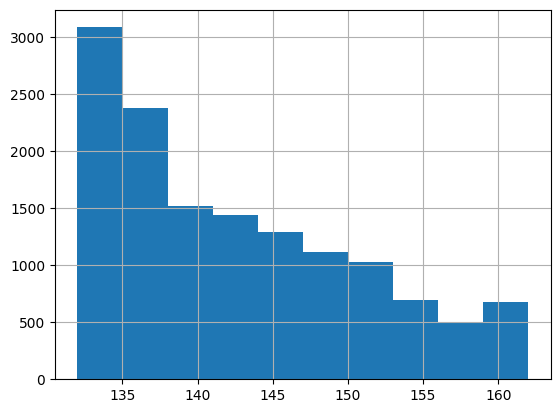

In [38]:
popular_items = df.item_id.value_counts()[:300].index.tolist() # 300 самых популярных items //Функция value_counts() подсчитывает уникальные значения и их частоту
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3784
# выбираются все взаимодействия (строки) из DataFrame df, где item_id соответствует sampled_id
interactions = df.loc[df.item_id==sampled_id].copy()
interactions.head()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(f'Название фильма: {name}')
interactions.last_watch_dt.hist()

Фильм Маленький воин был набирал популярность какое-то время, потом видим резкое падение (с какой даты, кстати?). Возможно связано с ограничением доступности к этому фильму, однако не всем участникам, либо же это период проката фильмы / рекламной кампании, и т.д.

Добавьте 5 своих примеров ниже. Опишите, как вы их искали

In [39]:
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
598,182977,3784,133,4163,82.0
619,72137,3784,138,6,0.0
770,785150,3784,143,6190,100.0
1086,1063946,3784,156,20442,100.0
1295,889595,3784,136,2269,45.0


ПРИМЕР №1 Анализ продолжительности просмотров 

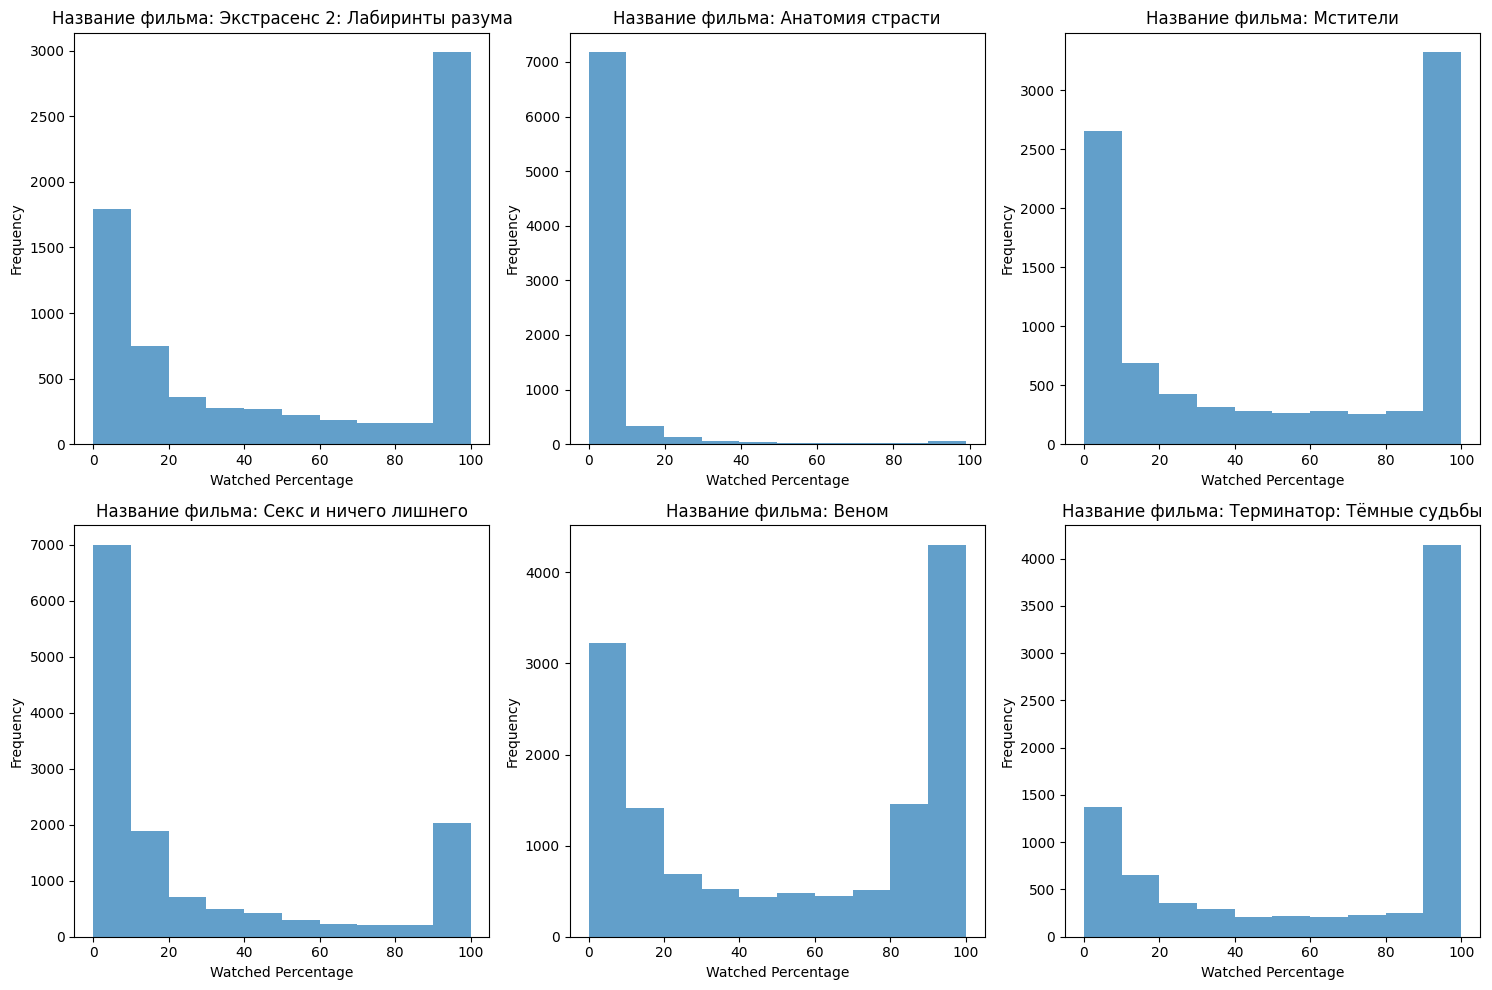

In [40]:
plt.figure(figsize=(15, 10))  


for i in range(6):
    plt.subplot(2, 3, i+1)
    
    popular_items = df.item_id.value_counts()[:300].index.tolist()
    sampled_id = np.random.choice(popular_items)

    interactions = df.loc[df.item_id==sampled_id].copy()
    name = items.loc[items.item_id==sampled_id].title.values[0]
    plt.hist(interactions.watched_pct, bins=10, alpha=0.7)  # Строим гистограмму для watched_pct
    plt.title(f'Название фильма: {name}')  
    plt.xlabel('Watched Percentage')
    plt.ylabel('Frequency')

plt.tight_layout()  # Для улучшения отображения подписей
plt.show()  

По данным гистограмма, можно сдлеать вывод, что в основном фильмы/сериалы или начинают смотреть и почти сразу же заканчивают(по какой либо причине. Например, не понравился и т.д.) или смотрят полностью

ПРИМЕР №2 анализа сезонности просмотров

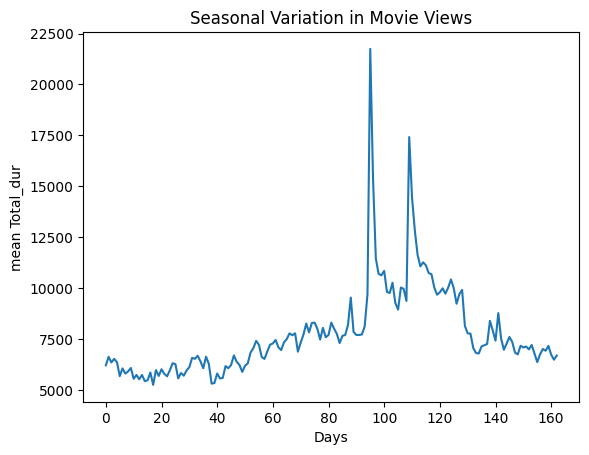

In [41]:
monthly_views = df.groupby(df['last_watch_dt'])['total_dur'].mean()
plt.plot(monthly_views)
plt.xlabel('Days')
plt.ylabel('mean Total_dur') #  средняя общая продолжительность всех просмотров данного контента в секундах
plt.title('Seasonal Variation in Movie Views')
plt.show()

Данные по просмотру контента собраны за ~6 месяцев, с 2021-03-13 по 2021-08-22  включительно. Видно, что с началом лета Общая продолжительность всех просмотров данного контента в секундах имеет резкий пик. А именно два пика с началом июня и июля. Это связано с тем, что у многих школьников/студентов в это время начинаются каникулы, а у взрослых отпуска.

ПРИМЕР №3 Сезонные колебания

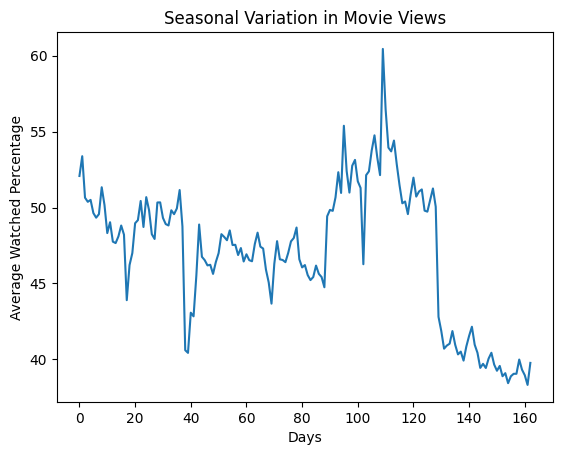

In [42]:
monthly_views = df.groupby(df['last_watch_dt'])['watched_pct'].mean()
plt.plot(monthly_views)
plt.xlabel('Days')
plt.ylabel('Average Watched Percentage')
plt.title('Seasonal Variation in Movie Views')
plt.show()

Данная зависимость также характеризует сезонность продолжительности просмотров. Видно, что с окончанием лета(Данные по просмотру контента собраны за ~6 месяцев, с 2021-03-13 по 2021-08-22  включительно) продолжительность просмотров резко падает, из-за начала учебного года/ конца отпусков и т.д.

ПРИМЕР №4 зависимость среднего времени последнего просмотра контента от процента просмотра (watched_pct)

Название фильма: Апгрейд


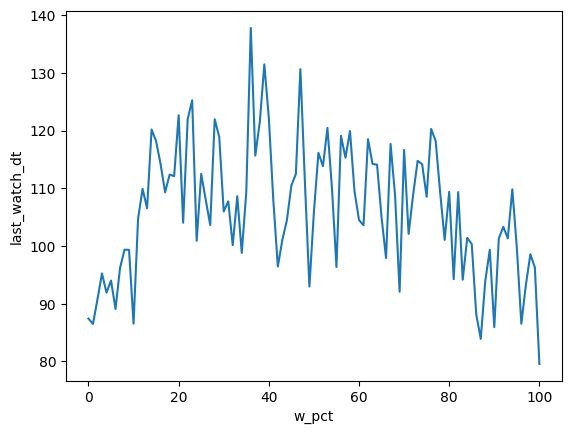

In [43]:
popular_items = df.item_id.value_counts()[:300].index.tolist() # 300 самых популярных items //Функция value_counts() подсчитывает уникальные значения и их частоту
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
# выбираются все взаимодействия (строки) из DataFrame df, где item_id соответствует sampled_id
interactions = df.loc[df.item_id==sampled_id].copy()
interactions.head()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(f'Название фильма: {name}')

monthly_views = interactions.groupby(interactions['watched_pct'])['last_watch_dt'].mean()
plt.plot(monthly_views) # ОТФИЛЬТРОВАТЬ ПО ФИЛЬМУ 
plt.xlabel('w_pct')
plt.ylabel('last_watch_dt') #  средняя общая продолжительность всех просмотров данного контента в секундах
plt.show()

Стабильность: Если среднее время последнего просмотра остается примерно одинаковым независимо от процента просмотра, это может указывать на стабильный интерес к контенту со временем. В этом случае можно предположить, что контент имеет постоянную аудитрию.

**Задание №5. User-item encoding**

Теперь создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить sparse matrix, в которой в качестве строк будут пользователи, в качестве колонок айтемы. Не забудьте закодировать пользователей и айтемы к "внутренней кодировке". В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас второе условие на минимальное число интеракций с айтемом перестанет выполняться. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это может нарушить снова условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока в обоих колонках не будет выполняться требование

In [44]:
def filter_column(df, min_freq):
    """
    Filter dataframe, excluding least active users and lest popular items.
    Should return copy of the dataframe with at least min_freq entries
    in both users and items
    """
    filtered_df = df.copy()
    user_counts = df['user_id'].value_counts() # {user : кол-во (популярность)}
    item_counts = df['item_id'].value_counts()
    # фильтруем 
    filtered_df  = filtered_df[df['user_id'].isin(user_counts[user_counts >= min_freq].index)] 
    filtered_df  = filtered_df[df['item_id'].isin(item_counts[item_counts >= min_freq].index)]

    return filtered_df 

#??????????????????????????? cols.......
def filter_dataframe(df, cols, min_freq=4): 
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Should return copy
    of the dataframe
    """
    filtered_df = df.copy()
    for col in cols:
        filtered_df = filter_column(filtered_df, min_freq)

    
    return filtered_df

In [45]:
filtered_train = filter_dataframe(df, ['user_id', 'item_id'])
filtered_train.head(), filtered_train.shape

C:\Users\master\AppData\Local\Temp\ipykernel_6612\1042251673.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df  = filtered_df[df['item_id'].isin(item_counts[item_counts >= min_freq].index)]
C:\Users\master\AppData\Local\Temp\ipykernel_6612\1042251673.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df  = filtered_df[df['item_id'].isin(item_counts[item_counts >= min_freq].index)]


(   user_id  item_id  last_watch_dt  total_dur  watched_pct
 0   176549     9506             59       4250         72.0
 1   699317     1659             77       8317        100.0
 3   864613     7638            114      14483        100.0
 5  1032142     6686             61      11286        100.0
 6  1016458      354            154       1672         25.0,
 (4540614, 5))

In [46]:
df.item_id.unique()

array([ 9506,  1659,  7107, ..., 10064, 13019, 10542], dtype=int64)

In [47]:
user2id = {k:v for v, k in enumerate(df.item_id.unique())} 
id2user = {k:v for v, k in user2id.items()}
print(user2id)  
print(id2user)


{9506: 0, 1659: 1, 7107: 2, 7638: 3, 6686: 4, 354: 5, 693: 6, 1449: 7, 13582: 8, 8199: 9, 7571: 10, 12173: 11, 496: 12, 8437: 13, 3043: 14, 16228: 15, 13865: 16, 9617: 17, 7793: 18, 8081: 19, 11754: 20, 15297: 21, 11367: 22, 12846: 23, 4398: 24, 10440: 25, 3935: 26, 2616: 27, 5732: 28, 6208: 29, 517: 30, 3813: 31, 9728: 32, 11640: 33, 11970: 34, 9427: 35, 1819: 36, 15373: 37, 5658: 38, 4566: 39, 10152: 40, 9298: 41, 9996: 42, 3614: 43, 12995: 44, 1931: 45, 11835: 46, 5648: 47, 9335: 48, 13933: 49, 15411: 50, 7626: 51, 3190: 52, 8143: 53, 16237: 54, 6330: 55, 14901: 56, 14488: 57, 4583: 58, 11699: 59, 4495: 60, 5220: 61, 8486: 62, 13165: 63, 3395: 64, 3071: 65, 4223: 66, 9194: 67, 11237: 68, 10464: 69, 3017: 70, 12299: 71, 512: 72, 11143: 73, 15947: 74, 9070: 75, 13000: 76, 5569: 77, 2293: 78, 13980: 79, 1465: 80, 14200: 81, 15998: 82, 13763: 83, 3734: 84, 14415: 85, 6192: 86, 12215: 87, 7545: 88, 9550: 89, 7737: 90, 14362: 91, 1916: 92, 2657: 93, 817: 94, 12770: 95, 579: 96, 9169: 97, 

In [48]:
def df_encode(df):
    item2id = {k:v for v, k in enumerate(df.item_id.unique())}
    user2id = {k:v for v, k in enumerate(df.user_id.unique())}

    id2item = {k:v for v, k in item2id.items()}
    id2user = {k:v for v, k in user2id.items()}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df

filtered_train_encode = df_encode(filtered_train)
filtered_train.head(), filtered_train.sample(5)

(   user_id  item_id  last_watch_dt  total_dur  watched_pct
 0        0        0             59       4250         72.0
 1        1        1             77       8317        100.0
 3        2        2            114      14483        100.0
 5        3        3             61      11286        100.0
 6        4        4            154       1672         25.0,
          user_id  item_id  last_watch_dt  total_dur  watched_pct
 1417834   123009       47            125        817         16.0
 747293     20209     1002            133       8247        100.0
 1020106   195181     1211             52       1507         25.0
 4801189   126256      301            146        783         14.0
 2609399   101720     5079            128        122          2.0)

Матрицу интеракций user-item 

In [108]:

from scipy import sparse as sps


df = filtered_train_encode
item2id = {k:v for v, k in enumerate(df.item_id.unique())}
user2id = {k:v for v, k in enumerate(df.user_id.unique())}
# sparse matrix //разреженная 
matrix = sps.coo_matrix(
    (np.ones(df.shape[0]), (df['user_id'], df['item_id'])),
    shape=(len(user2id), len(item2id)),
)

**Задание №6. Интерации и частота**

Нужно построить график на число айтемов и юзеров, которые остаются в матрице интеракций в зависимости от строгости фильтров на встречаемость. То есть нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра

In [50]:
# # Различные значения min_freq для анализа
# min_freq_values = [5, 10, 15, 20, 30, 39, 49, 59, 80]

# num_items_remaining = []
# num_users_remaining = []

# for min_freq in min_freq_values:
#     filtered_df = filter_dataframe(df, ['user_id', 'item_id'], min_freq)
    
#     # Создание словарей item2id и user2id
#     item2id = {item: idx for idx, item in enumerate(filtered_df['item_id'].unique())}
#     user2id = {user: idx for idx, user in enumerate(filtered_df['user_id'].unique())}
    
    
#     num_items_remaining.append(len(item2id))
#     num_users_remaining.append(len(user2id))

# # Построение графика зависимости числа оставшихся айтемов и юзеров от параметра min_freq
# plt.figure(figsize=(10, 6))
# plt.plot(min_freq_values, num_items_remaining, label='Number of Items Remaining')
# plt.plot(min_freq_values, num_users_remaining, label='Number of Users Remaining')
# plt.xlabel('Min Frequency')
# plt.ylabel('Number of Items/Users')
# plt.title('Number of Items and Users Remaining vs Min Frequency')
# plt.legend()
# plt.grid()
# plt.show()
# None

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все метрики качества с `TopPopular` для некоторого набора k

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole

In [100]:

id2item = {k:v for v, k in item2id.items()}
print(matrix)
print(matrix.shape)

  (0, 0)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 6)	1.0
  (7, 7)	1.0
  (8, 8)	1.0
  (9, 9)	1.0
  (10, 10)	1.0
  (11, 11)	1.0
  (12, 12)	1.0
  (13, 13)	1.0
  (14, 14)	1.0
  (15, 15)	1.0
  (16, 16)	1.0
  (17, 17)	1.0
  (18, 18)	1.0
  (19, 19)	1.0
  (20, 20)	1.0
  (21, 21)	1.0
  (22, 22)	1.0
  (23, 23)	1.0
  (24, 24)	1.0
  :	:
  (150708, 1735)	1.0
  (109682, 1598)	1.0
  (135117, 1602)	1.0
  (328305, 1493)	1.0
  (355306, 1887)	1.0
  (146624, 749)	1.0
  (42861, 96)	1.0
  (30856, 761)	1.0
  (220359, 8)	1.0
  (84072, 7744)	1.0
  (124771, 384)	1.0
  (1682, 93)	1.0
  (298279, 184)	1.0
  (218505, 488)	1.0
  (80693, 3222)	1.0
  (8631, 801)	1.0
  (195265, 181)	1.0
  (16020, 61)	1.0
  (60265, 2706)	1.0
  (152823, 52)	1.0
  (142276, 2330)	1.0
  (60987, 208)	1.0
  (35695, 200)	1.0
  (167548, 2542)	1.0
  (6567, 1609)	1.0
(962179, 15706)


In [112]:
matrix.shape

(366964, 10834)

In [113]:
import numpy as np
import scipy.sparse as sps

def fit_ease(matrix, lambda_reg=1000):
    #  Грам-матрица
    G = matrix.T.dot(matrix)  
    #индексы элементов на диагонали
    diagIndices = np.diag_indices(G.A.shape[0])
    G[diagIndices] += lambda_reg

    #Вычислить обратную Грам-матрицу.
    P = np.linalg.inv(G.A)
    B = P / (-np.diag(P))
    B[diagIndices] = 0
    
    return B

# Пример вызова функции fit_ease с матрицей matrix
W = fit_ease(matrix)

In [114]:
W.shape, W

((10834, 10834),
 array([[ 0.00000000e+00,  5.48881998e-03, -1.02790272e-03, ...,
         -2.63264619e-05,  6.75099595e-06,  1.96138635e-04],
        [ 1.21638683e-02,  0.00000000e+00,  9.03569021e-04, ...,
         -1.97000522e-05, -2.35894837e-06,  4.44488157e-04],
        [-2.04774718e-03,  8.12256003e-04,  0.00000000e+00, ...,
         -7.21859660e-05, -3.46278324e-06, -7.44480857e-05],
        ...,
        [-1.06497237e-04, -3.59600675e-05, -1.46579858e-04, ...,
          0.00000000e+00, -8.66565536e-07, -1.52939330e-05],
        [ 2.73259352e-05, -4.30856747e-06, -7.03571393e-06, ...,
         -8.67087160e-07,  0.00000000e+00,  5.67941397e-07],
        [ 7.93219851e-04,  8.11143884e-04, -1.51133118e-04, ...,
         -1.52898690e-05,  5.67448909e-07,  0.00000000e+00]]))

In [115]:
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopular_recs_window,ease_preds
0,17,"[(3734, 141), (10196, 146), (8618, 146)]","[(9342, 155)]","[3520, 15874, 12549]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 13865, 15297, 9728, 4151, 3734, 4880, ...","[0.1094743600500423, 0.9530575556792424, 0.953..."
1,55,"[(9896, 15), (6192, 60), (3076, 99), (15297, 1...","[(14, 156)]","[3520, 15874, 12549]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 13865, 15297, 9728, 4151, 3734, 4880, ...","[0.0, 0.0, 0.3110824292846359, 0.1197930572721..."
2,165,"[(12173, 122)]","[(4969, 161)]","[3520, 15874, 12549]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 13865, 15297, 9728, 4151, 3734, 4880, ...",[0.09267387175019803]
3,170,"[(13237, 152), (4331, 152)]","[(1453, 153), (741, 154), (15679, 154), (11083...","[3520, 15874, 12549]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 13865, 15297, 9728, 4151, 3734, 4880, ...","[0.0, 0.0]"
4,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214...","[3520, 15874, 12549]","[10440, 9728, 15297, 13865, 3734, 4151, 4880, ...","[10440, 13865, 15297, 9728, 4151, 3734, 4880, ...","[0.9704515351915103, 0.3010037647219293]"


In [116]:
print(item2id)
print(id2item)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97, 98: 98, 99: 99, 100: 100, 101: 101, 102: 102, 103: 103, 104: 104, 105: 105, 106: 106, 107: 107, 108: 108, 109: 109, 110: 110, 111: 111, 112: 112, 113: 113, 114: 114, 115: 115, 116: 116, 117: 117, 118: 118, 119: 119, 120: 120, 121: 121,

In [117]:
def get_preds(x, item2id, id2item, w):
    preds = []
    for user_id, item_id in x:
        if item_id in item2id:
            item_idx = item2id[item_id]
            pred = sum(w[item_idx] for w in w)  # Вычисление предсказанного рейтинга
            preds.append(pred)
    return preds


In [133]:
def get_preds2(x, item2id, id2item, w, topn):
    # Преобразование вектора интеракций пользователя в формат CSR
    user_vector = np.zeros(len(item2id))
    for item_id in x:
        if item_id in item2id:
            user_vector[item2id[item_id]] = 1
    preds = user_vector.dot(w)  # Умножение на матрицу весов
    
    # Декодирование предсказаний
    decoded = [id2item[i] for i in np.argsort(-preds)]

    return decoded[:topn]

Далее вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя, и умножить его на матрицу весов

In [136]:
joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds2(x, item2id, id2item, W, 20))
joined.head()

In [130]:
evaluate_recommender(joined, model_preds='ease_preds')

{'MAP': 0.0014057791272503594, 'MRR': 0.004040957922020057, 'HR': 0.9993}

In [135]:
x = joined['test_interactions'][1]
print(x)
preds = get_preds2(x, item2id, id2item, W, 20)
print(preds)

[(14, 156)]
[9506, 4216, 5286, 13680, 962, 11762, 9411, 13809, 9225, 15861, 7725, 6694, 5857, 7322, 998, 5248, 6682, 7916, 7496, 6658]


Сделайте выводы — какой алгоритм работает лучше?

**Ответ:**

**Задание №8. Тюнинг**

Теперь проварьируйте параметр регуляризации у EASE и постройте все те же графики, что и в задании №6, только путем варирования различных значениях гиперпараметра коэффициента регуляризации. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации

In [ ]:
lambda_reg = [1, 10, 50, 100, 200, 500, 1000, 2000, 3500, 5000, 9000]

Ответьте на следующие вопросы:

Какое значение гиперпараметра является наилучшим? \\
**Ответ:**

Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга? \
**Ответ:**

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым встречаемости user/item (из задания №6). Сделайте выводы

Важно, в этом задании линии могут быть мало разлимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали отличимыми

Что вы можете сказать по графикам? Соответствуют ли они вашим ожиданиям?

**Ответ:**

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов

In [ ]:
# your code here

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:**